# Курсовой проект(постановка задачи и описание)

## Постановка задачи

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной (0 или 1, а НЕ вероятность) для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

## Примерное описание этапов выполнения курсового проекта

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

## Обзор данных


**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - оценка благонадежности клиента (скоринговый балл, полученный из другого источника)
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

# Курсовой проект(выполнение)

# Предобработка данных

## Подключение библиотек и скриптов

In [1237]:
#! pip install catboost

In [1238]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn import preprocessing
from sklearn.metrics import r2_score as r2
import sklearn.linear_model as lm
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency

from statsmodels.stats.weightstats import zconfint

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

import math
from collections import OrderedDict
import pickle

In [1239]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [1240]:
def print_stat(y_train_preds, y_test_preds):
  precision1, recall1, F_11 = precision_score(y_train, y_train_preds), recall_score(y_train, y_train_preds), f1_score(y_train, y_train_preds)
  precision2, recall2, F_12 = precision_score(y_val, y_test_preds), recall_score(y_val, y_test_preds), f1_score(y_val, y_test_preds)
  precision1, recall1, F_11 = round(precision1, 3), round(recall1, 3), round(F_11, 3)
  precision2, recall2, F_12 = round(precision2, 3), round(recall2, 3), round(F_12, 3)
  print(f'#    train precision {precision1},  recall {recall1}, F_1 мера {F_11}')
  print(f'#    test precision {precision2},  recall {recall2}, F_1 мера {F_12}')

In [1241]:
def print_stat1( y_train_preds, y_test_preds):
  precision1, recall1, F_11 = precision_score(y_train, y_train_preds), recall_score(y_train, y_train_preds), f1_score(y_train, y_train_preds)
  precision2, recall2, F_12 = precision_score(y_val, y_test_preds), recall_score(y_val, y_test_preds), f1_score(y_val, y_test_preds)
  precision1, recall1, F_11 = round(precision1, 3), round(recall1, 3), round(F_11, 3)
  precision2, recall2, F_12 = round(precision2, 3), round(recall2, 3), round(F_12, 3)
  if F_12> 0.5 and precision2 > 0.5 and recall2>0.5:
    print(f'#    train precision {precision1},  recall {recall1}, F_1 мера {F_11}')
    print(f'#    test precision {precision2},  recall {recall2}, F_1 мера {F_12}')

In [1242]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [1243]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [1244]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [1245]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

## Пути к директориям и файлам

In [1388]:
# input
TRAIN_DATASET_PATH = '../content/drive/My Drive/proj/course_project_train.csv'
TEST_DATASET_PATH = '../content/drive/My Drive/proj/course_project_test.csv'

# output
PREP_DATASET_PATH = '../content/drive/My Drive/proj/project_data_prep.csv'
FINAL_DATASET_PATH_ONLY_PRED = '../content/drive/My Drive/proj/BabinaLA_only_predictions.csv'
FINAL_DATASET_PATH_FULL = '../content/drive/My Drive/proj/BabinaLA_predictions_with_data.csv'

MODEL_FILE_PATH = '../content/drive/My Drive/proj/model.pkl'


## Загрузка данных

In [1247]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [1248]:
df.shape

(7500, 17)

In [1249]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [1250]:
df_test.shape

(2500, 16)

In [1251]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [1252]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [1253]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

## Приведение типов

In [1254]:
#в датасете 4 категориальных признака - зададим тип объектов
Cat_prizn = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
for colname in Cat_prizn:
    df[colname] = df[colname].astype(str)

In [1255]:
#в датасете 4 категориальных признака - зададим тип объектов
Cat_prizn_test = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
for colname in Cat_prizn_test:
    df_test[colname] = df_test[colname].astype(str)

## Обзор данных

**Обзор целевой переменной**

In [1256]:
df['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

**Обзор количественных признаков**

In [1257]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [1258]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


**Обзор номинативных/категориальных признаков**

In [1259]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses 

In [1260]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
nan           86
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
movi

В датасете трейн есть дополнительная категория renewable energy в признаке Purpose(там всего 2 значения - не критично)
В остальном все одинаково

## Обработка пропусков

**Annual Income**

In [1261]:
df['Annual Income'].value_counts(dropna=False)

NaN          1557
1161660.0       4
1058376.0       4
1043651.0       4
1338113.0       4
             ... 
1141254.0       1
7907382.0       1
1534478.0       1
972040.0        1
585751.0        1
Name: Annual Income, Length: 5479, dtype: int64

In [1262]:
df_test['Annual Income'].value_counts(dropna=False)

NaN          513
1328803.0      3
1237109.0      3
1025145.0      3
1214993.0      3
            ... 
641687.0       1
2304624.0      1
985758.0       1
1389888.0      1
1486845.0      1
Name: Annual Income, Length: 1930, dtype: int64

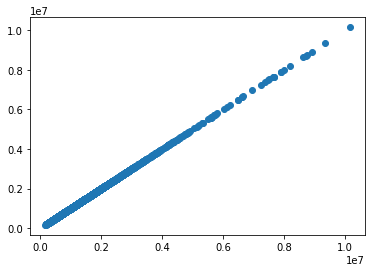

In [1263]:
plt.scatter(df['Annual Income'], df['Annual Income'])
plt.show()

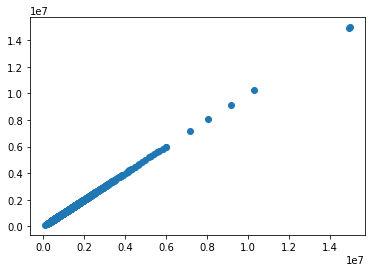

In [1264]:
plt.scatter(df_test['Annual Income'], df_test['Annual Income'])
plt.show()

In [1265]:
len(df[df['Annual Income']> 4000000])

91

In [1266]:
len(df_test[df_test['Annual Income']> 4000000])

27

In [1267]:
df[df['Annual Income']<0].shape

(0, 17)

Так как пропусков достаточно много - около 20 процентов, то для начала заполним пропуски значением -1, а в изменим эти значения (обучим модель)

In [1268]:
df['Annual Income']=df['Annual Income'].fillna(-1)

In [1269]:
df_test['Annual Income']=df_test['Annual Income'].fillna(-1)

**Years in current job**

In [1270]:
df['Years in current job'].value_counts(dropna=False)

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [1271]:
df_test['Years in current job'].value_counts(dropna=False)

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
nan           86
Name: Years in current job, dtype: int64

In [1272]:
#заменим наиболее часто встречающимися значениями
df.loc[df['Years in current job']=='nan', 'Years in current job'] = '10+ years'
df_test.loc[df_test['Years in current job']=='nan', 'Years in current job'] = '10+ years'

**Months since last delinquent**

In [1273]:
df['Months since last delinquent'].value_counts(dropna=False)

NaN      4081
14.0       76
29.0       71
8.0        68
33.0       68
         ... 
84.0        1
92.0        1
86.0        1
118.0       1
91.0        1
Name: Months since last delinquent, Length: 90, dtype: int64

In [1274]:
df_test['Months since last delinquent'].value_counts(dropna=False)

NaN     1358
16.0      30
23.0      28
14.0      28
24.0      26
        ... 
60.0       5
81.0       5
64.0       5
65.0       5
82.0       3
Name: Months since last delinquent, Length: 84, dtype: int64

In [1275]:
df[df['Months since last delinquent']<0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [1276]:
df_test[df_test['Months since last delinquent']<0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


Так как пропусков достаточно много - больше 50 процентов, то для начала заполним пропуски значением -1, а в изменим эти значения (обучим модель)

In [1277]:
df['Months since last delinquent']=df['Months since last delinquent'].fillna(-1)
df_test['Months since last delinquent']=df_test['Months since last delinquent'].fillna(-1)

**Credit Score**

In [1278]:
df['Credit Score'].value_counts(dropna=False)

NaN       1557
740.0      169
747.0      168
748.0      157
745.0      152
          ... 
602.0        1
616.0        1
585.0        1
620.0        1
7010.0       1
Name: Credit Score, Length: 269, dtype: int64

In [1279]:
df_test['Credit Score'].value_counts(dropna=False)

NaN       513
746.0      56
739.0      55
741.0      54
740.0      50
         ... 
6850.0      1
6310.0      1
6150.0      1
6840.0      1
6670.0      1
Name: Credit Score, Length: 212, dtype: int64

In [1280]:
df[df['Credit Score']<=0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [1281]:
df_test[df_test['Credit Score']<=0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


In [1282]:
# заполним все пропуски в столбце скоринга нулями, далее обучим модель
df['Credit Score']=df['Credit Score'].fillna(0)
df_test['Credit Score']=df_test['Credit Score'].fillna(0)

**Bankruptcies**

In [1283]:
df['Bankruptcies'].value_counts(dropna=False)

0.0    6660
1.0     786
2.0      31
NaN      14
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [1284]:
df_test['Bankruptcies'].value_counts(dropna=False)

0.0    2252
1.0     234
2.0       5
3.0       3
NaN       3
5.0       2
4.0       1
Name: Bankruptcies, dtype: int64

In [1285]:
#заменим наиболее встречающимся значением
df['Bankruptcies']=df['Bankruptcies'].fillna(0)
df_test['Bankruptcies']=df_test['Bankruptcies'].fillna(0)

In [1286]:
len(df) - df.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [1287]:
len(df_test) - df_test.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

## Обработка выбросов

### Home Ownership - категориальный признак

In [1288]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [1289]:
df_test['Home Ownership'].value_counts()

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64

### Years in current job - категориальный признак

In [1290]:
#оставляем так
df['Years in current job'].value_counts(dropna=False)

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [1291]:
df_test['Years in current job'].value_counts(dropna=False)

10+ years    896
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64

### Annual Income

In [1292]:
df['Annual Income'].value_counts(dropna = False)

-1.0          1557
 1161660.0       4
 1058376.0       4
 1043651.0       4
 1338113.0       4
              ... 
 1141254.0       1
 7907382.0       1
 1534478.0       1
 972040.0        1
 585751.0        1
Name: Annual Income, Length: 5479, dtype: int64

In [1293]:
df_test['Annual Income'].value_counts(dropna = False)

-1.0          513
 1328803.0      3
 1237109.0      3
 1025145.0      3
 1214993.0      3
             ... 
 641687.0       1
 2304624.0      1
 985758.0       1
 1389888.0      1
 1486845.0      1
Name: Annual Income, Length: 1930, dtype: int64

((array([-3.67998084, -3.44731998, -3.31922171, ...,  3.31922171,
          3.44731998,  3.67998084]),
  array([  164597.,   175845.,   177251., ...,  8923844.,  9338880.,
         10149344.])),
 (743996.4789333917, 1366391.7201749957, 0.8796869995004449))

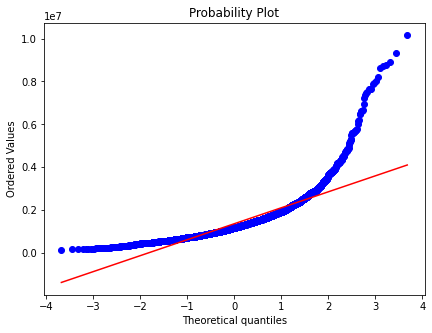

In [1294]:
x = df[df['Annual Income']>=0]['Annual Income'].values
fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
probplot (x=x, plot= plt)

In [1295]:
df.loc[df['Annual Income']> 4000000, 'Annual Income'] = -1
df_test.loc[df_test['Annual Income']> 4000000, 'Annual Income'] = -1

### Tax Liens

In [1296]:
#объединим значения больше 3
df.loc[df['Tax Liens']> 3, 'Tax Liens'] = 3
df_test.loc[df_test['Tax Liens']> 3, 'Tax Liens'] = 3

### Number of Open Accounts

In [1297]:
x = []
for i in range(len(df['Number of Open Accounts'])):
  a = df['Number of Open Accounts'][i]
  x.append(a**0.3)

((array([-3.73889526, -3.50968086, -3.3836472 , ...,  3.3836472 ,
          3.50968086,  3.73889526]),
  array([1.23114441, 1.23114441, 1.23114441, ..., 3.04673833, 3.06884382,
         3.09058389])),
 (0.2662954723411313, 2.0199037640355524, 0.9968819134449317))

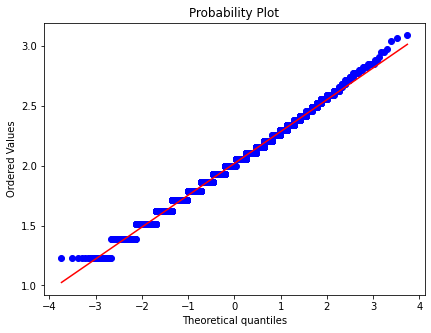

In [1298]:
#x = df['Number of Open Accounts'].values
fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
probplot (x=x, plot= plt)

In [1299]:
#Number of Open Accounts уберем выбросы - +- три сигмы
mean = df['Number of Open Accounts'].mean()
std = df['Number of Open Accounts'].std()

df.loc[df['Number of Open Accounts'] < (mean - 3* std), 'Number of Open Accounts'] = mean
df.loc[df['Number of Open Accounts'] > (mean + 3* std), 'Number of Open Accounts'] = mean

mean_test = df_test['Number of Open Accounts'].mean()
std_test = df_test['Number of Open Accounts'].std()

df_test.loc[df_test['Number of Open Accounts'] < (mean_test - 3* std_test), 'Number of Open Accounts'] = mean_test
df_test.loc[df_test['Number of Open Accounts'] > (mean_test + 3* std_test), 'Number of Open Accounts'] = mean_test

### Years of Credit History

In [1300]:
df['Years of Credit History'].value_counts(dropna=False)
# если смотреть продолжительность жизни https://gtmarket.ru/ratings/life-expectancy-index
# и ориентироваться на Россию - то это 72 года, соответвенно кредит можно взять в 18, то есть максимальное среднее время 
# возраст кредитной истории 56 лет
# В датасете макисмально 57,7 - вцелом можно оставить так и не принимать такие значения за выброс

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.2      1
4.9       1
39.5      1
42.4      1
39.8      1
Name: Years of Credit History, Length: 408, dtype: int64

In [1301]:
df_test['Years of Credit History'].max()

53.4

### Maximum Open Credit

In [1302]:
#Maximum Open Credit уберем выбросы - +- три сигмы

mean = df['Maximum Open Credit'].mean()
std = df['Maximum Open Credit'].std()
df.loc[df['Maximum Open Credit']==0, 'Maximum Open Credit'] = df['Maximum Open Credit'].mean()
df.loc[df['Maximum Open Credit'] < (mean - 3* std), 'Maximum Open Credit'] = df['Maximum Open Credit'].mean()
df.loc[df['Maximum Open Credit'] > (mean + 3* std), 'Maximum Open Credit'] = df['Maximum Open Credit'].mean()


mean_test = df_test['Maximum Open Credit'].mean()
std_test = df_test['Maximum Open Credit'].std()
df_test.loc[df['Maximum Open Credit']==0, 'Maximum Open Credit'] = df_test['Maximum Open Credit'].mean()
df_test.loc[df['Maximum Open Credit'] < (mean_test - 3* std_test), 'Maximum Open Credit'] = df_test['Maximum Open Credit'].mean()
df_test.loc[df['Maximum Open Credit'] > (mean_test + 3* std_test), 'Maximum Open Credit'] = df_test['Maximum Open Credit'].mean()

### Number of Credit Problems

In [1303]:
#Number of Credit Problems - объединим все значения больше 4
df.loc[df['Number of Credit Problems'] > 4, 'Number of Credit Problems'] = 4
df_test.loc[df_test['Number of Credit Problems'] > 4, 'Number of Credit Problems'] = 4

### Bankruptcies

In [1304]:
df.loc[df['Bankruptcies'] > 2, 'Bankruptcies'] = 2
df_test.loc[df_test['Bankruptcies'] > 2, 'Bankruptcies'] = 2

### Current Loan Amount

In [1305]:
mean = df['Current Loan Amount'].mean()
std = df['Current Loan Amount'].std()

df.loc[df['Current Loan Amount'] < (mean - 3* std), 'Current Loan Amount'] = df['Current Loan Amount'].mean()
df.loc[df['Current Loan Amount'] > (mean + 3* std), 'Current Loan Amount'] = df['Current Loan Amount'].mean()

mean_test = df_test['Current Loan Amount'].mean()
std_test = df_test['Current Loan Amount'].std()

df_test.loc[df_test['Current Loan Amount'] < (mean_test - 3* std_test), 'Current Loan Amount'] = df_test['Current Loan Amount'].mean()
df_test.loc[df_test['Current Loan Amount'] > (mean_test + 3* std_test), 'Current Loan Amount'] = df_test['Current Loan Amount'].mean()

### Current Credit Balance

In [1306]:
mean = df['Current Credit Balance'].mean()
std = df['Current Credit Balance'].std()

df.loc[df['Current Credit Balance'] < (mean - 3* std), 'Current Credit Balance'] = mean
df.loc[df['Current Credit Balance'] > (mean + 3* std), 'Current Credit Balance'] = mean

mean_test = df_test['Current Credit Balance'].mean()
std_test = df_test['Current Credit Balance'].std()

df_test.loc[df_test['Current Credit Balance'] < (mean_test - 3* std_test), 'Current Credit Balance'] = mean_test
df_test.loc[df_test['Current Credit Balance'] > (mean_test + 3* std_test), 'Current Credit Balance'] = mean_test

### Monthly Debt

In [1307]:
mean = df['Monthly Debt'].mean()
std = df['Monthly Debt'].std()

df.loc[df['Monthly Debt'] < (mean - 3* std), 'Monthly Debt'] = mean
df.loc[df['Monthly Debt'] > (mean + 3* std), 'Monthly Debt'] = mean

mean_test = df_test['Monthly Debt'].mean()
std_test = df_test['Monthly Debt'].std()

df_test.loc[df_test['Monthly Debt'] < (mean_test - 3* std_test), 'Monthly Debt'] = mean_test
df_test.loc[df_test['Monthly Debt'] > (mean_test + 3* std_test), 'Monthly Debt'] = mean_test

### Credit Score

In [1308]:
#оставляем как есть, так как пробовали заменить нулями и дальще обучить модель 
#или разделить на 10 - но качество общей модели ухудшилось
len(df[df['Credit Score']>1000])

400

In [1309]:
len(df_test[df_test['Credit Score']>1000])

160

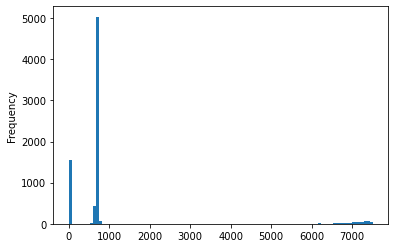

In [1310]:
df["Credit Score"].plot(kind="hist", bins=100)

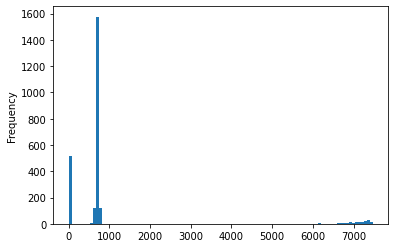

In [1311]:
df_test["Credit Score"].plot(kind="hist", bins=100)

## Создание новых признаков

### Home Ownership - dummies

In [1312]:
#лучше работает чем просто в одной колонке категории
df= pd.get_dummies(df, prefix='Home Ownership_', columns=['Home Ownership'])
df_test= pd.get_dummies(df_test, prefix='Home Ownership_', columns=['Home Ownership'])

### Years in current job - изменили названия категорий

In [1313]:
#Years in current job
#Заменим NaN на моду и остальное сделаем категории от 0 до 10 по возрастанию(dummies получается хуже)

df.loc[df['Years in current job']=='< 1 year', 'Years in current job'] = 0
df.loc[df['Years in current job']=='1 year', 'Years in current job'] = 1
df.loc[df['Years in current job']=='2 years', 'Years in current job'] = 2
df.loc[df['Years in current job']=='3 years', 'Years in current job'] = 3
df.loc[df['Years in current job']=='4 years', 'Years in current job'] = 4
df.loc[df['Years in current job']=='5 years', 'Years in current job'] = 5
df.loc[df['Years in current job']=='6 years', 'Years in current job'] = 6
df.loc[df['Years in current job']=='7 years', 'Years in current job'] = 7
df.loc[df['Years in current job']=='8 years', 'Years in current job'] = 8
df.loc[df['Years in current job']=='9 years', 'Years in current job'] = 9
df.loc[df['Years in current job']=='10+ years', 'Years in current job'] = 10

df_test.loc[df_test['Years in current job']=='< 1 year', 'Years in current job'] = 0
df_test.loc[df_test['Years in current job']=='1 year', 'Years in current job'] = 1
df_test.loc[df_test['Years in current job']=='2 years', 'Years in current job'] = 2
df_test.loc[df_test['Years in current job']=='3 years', 'Years in current job'] = 3
df_test.loc[df_test['Years in current job']=='4 years', 'Years in current job'] = 4
df_test.loc[df_test['Years in current job']=='5 years', 'Years in current job'] = 5
df_test.loc[df_test['Years in current job']=='6 years', 'Years in current job'] = 6
df_test.loc[df_test['Years in current job']=='7 years', 'Years in current job'] = 7
df_test.loc[df_test['Years in current job']=='8 years', 'Years in current job'] = 8
df_test.loc[df_test['Years in current job']=='9 years', 'Years in current job'] = 9
df_test.loc[df_test['Years in current job']=='10+ years', 'Years in current job'] = 10

###Purpose

In [1314]:
#Заменим названия на численные значения
df.loc[df['Purpose']== 'debt consolidation', 'Purpose'] = 0
df.loc[df['Purpose']== 'other', 'Purpose'] = 1
df.loc[df['Purpose']== 'home improvements', 'Purpose'] = 2
df.loc[df['Purpose']== 'business loan', 'Purpose'] = 3
df.loc[df['Purpose']== 'buy a car', 'Purpose'] = 4
df.loc[df['Purpose']== 'medical bills', 'Purpose'] = 5
df.loc[df['Purpose']== 'major purchase', 'Purpose'] = 6
df.loc[df['Purpose']== 'take a trip', 'Purpose'] = 7
df.loc[df['Purpose']== 'buy house', 'Purpose'] = 8
df.loc[df['Purpose']== 'small business', 'Purpose'] = 9
df.loc[df['Purpose']== 'wedding', 'Purpose'] = 10
df.loc[df['Purpose']== 'moving', 'Purpose'] = 11
df.loc[df['Purpose']== 'educational expenses', 'Purpose'] = 12
df.loc[df['Purpose']== 'vacation', 'Purpose'] = 13
df.loc[df['Purpose']== 'renewable energy', 'Purpose'] = 14


df_test.loc[df_test['Purpose']== 'debt consolidation', 'Purpose'] = 0
df_test.loc[df_test['Purpose']== 'other', 'Purpose'] = 1
df_test.loc[df_test['Purpose']== 'home improvements', 'Purpose'] = 2
df_test.loc[df_test['Purpose']== 'business loan', 'Purpose'] = 3
df_test.loc[df_test['Purpose']== 'buy a car', 'Purpose'] = 4
df_test.loc[df_test['Purpose']== 'medical bills', 'Purpose'] = 5
df_test.loc[df_test['Purpose']== 'major purchase', 'Purpose'] = 6
df_test.loc[df_test['Purpose']== 'take a trip', 'Purpose'] = 7
df_test.loc[df_test['Purpose']== 'buy house', 'Purpose'] = 8
df_test.loc[df_test['Purpose']== 'small business', 'Purpose'] = 9
df_test.loc[df_test['Purpose']== 'wedding', 'Purpose'] = 10
df_test.loc[df_test['Purpose']== 'moving', 'Purpose'] = 11
df_test.loc[df_test['Purpose']== 'educational expenses', 'Purpose'] = 12
df_test.loc[df_test['Purpose']== 'vacation', 'Purpose'] = 13



###Term

In [1315]:
df.loc[df['Term']== 'Short Term', 'Term'] = 1
df.loc[df['Term']== 'Long Term', 'Term'] = 0

df_test.loc[df_test['Term']== 'Short Term', 'Term'] = 1
df_test.loc[df_test['Term']== 'Long Term', 'Term'] = 0

### Annual Income

In [1316]:
# удалим целевой признак из датафрейма и признаки с большим количеством пропусков
df_for_mon = df.copy()
df_for_mon.drop(columns=['Credit Default'], inplace=True)
df_for_mon.drop(columns=['Credit Score'], inplace=True)
df_for_mon.drop(columns=['Months since last delinquent'], inplace=True)

In [1317]:
minmax = MinMaxScaler()
df_for_mon[['Tax Liens', 'Number of Open Accounts', 'Years of Credit History','Maximum Open Credit', 
            'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt'
            ]]  = minmax.fit_transform(df_for_mon[[
            'Tax Liens', 'Number of Open Accounts', 'Years of Credit History','Maximum Open Credit', 
            'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt'
       ]])

In [1318]:
#разделим датафрейм на две части - трейн где Annual Income больше 0 и тест где скоринг равен -1
df_for_mon1 = df_for_mon[df_for_mon['Annual Income'] > 0]#в этом датафрейме все записи с Annual Income
df_for_mon0 = df_for_mon[df_for_mon['Annual Income'] == -1]# в этом датафрейме все записи без Annual Income

df_for_mon1_for_model = df_for_mon1.copy(deep=True)
df_for_mon0_for_model = df_for_mon0.copy(deep=True)

In [1319]:
df_for_mon0_for_model.drop(columns=['Annual Income'], inplace=True)
y = df_for_mon1_for_model['Annual Income']
df_for_mon1_for_model.drop(columns=['Annual Income'], inplace=True)
X = df_for_mon1_for_model

In [1320]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=22)
skm = lm.LinearRegression()
skm.fit(X_train, y_train)
y_train_preds = skm.predict(X_train)
y_test_preds = skm.predict(X_val)
print(r2(y_train, y_train_preds))
print(r2(y_val, y_test_preds))

0.3614453876364412
0.3730312390550927


In [1321]:
y_test_fordf = skm.predict(df_for_mon0_for_model)
df_for_mon0['Annual Income'] = y_test_fordf
# опять объединим два датафрейма и упорядочим по индексу
df_all_full = pd.concat([df_for_mon1, df_for_mon0], ignore_index=False)
df_all_full.sort_index(inplace=True)
#внесем credit score в начальные датафреймы
df['Annual Income'] = df_all_full['Annual Income']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1322]:
# df_test
# удалим признаки с большим количеством пропусков
df_for_mon = df_test.copy()
df_for_mon.drop(columns=['Credit Score'], inplace=True)
df_for_mon.drop(columns=['Months since last delinquent'], inplace=True)

In [1323]:
minmax = MinMaxScaler()
df_for_mon[['Tax Liens', 'Number of Open Accounts', 'Years of Credit History','Maximum Open Credit', 
            'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt'
            ]]  = minmax.fit_transform(df_for_mon[[
            'Tax Liens', 'Number of Open Accounts', 'Years of Credit History','Maximum Open Credit', 
            'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt'
       ]])

In [1324]:
#разделим датафрейм на две части - трейн где Annual Income больше 0 и тест где скоринг равен -1
df_for_mon1 = df_for_mon[df_for_mon['Annual Income'] > 0]#в этом датафрейме все записи с Annual Income
df_for_mon0 = df_for_mon[df_for_mon['Annual Income'] == -1]# в этом датафрейме все записи без Annual Income

df_for_mon1_for_model = df_for_mon1.copy(deep=True)
df_for_mon0_for_model = df_for_mon0.copy(deep=True)

In [1325]:
df_for_mon0_for_model.drop(columns=['Annual Income'], inplace=True)
y = df_for_mon1_for_model['Annual Income']
df_for_mon1_for_model.drop(columns=['Annual Income'], inplace=True)
X = df_for_mon1_for_model

In [1326]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=22)
skm = lm.LinearRegression()
skm.fit(X_train, y_train)
y_train_preds = skm.predict(X_train)
y_test_preds = skm.predict(X_val)
print(r2(y_train, y_train_preds))
print(r2(y_val, y_test_preds))

0.3232435092614575
0.3508147432699281


In [1327]:
y_test_fordf = skm.predict(df_for_mon0_for_model)
df_for_mon0['Annual Income'] = y_test_fordf
# опять объединим два датафрейма и упорядочим по индексу
df_all_full = pd.concat([df_for_mon1, df_for_mon0], ignore_index=False)
df_all_full.sort_index(inplace=True)
#внесем credit score в начальные датафреймы
df_test['Annual Income'] = df_all_full['Annual Income']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Months since last delinquent

In [1328]:
# удалим целевой признак из датафрейма и признак скоринга
df_for_mon = df.copy()
df_for_mon.drop(columns=['Credit Default'], inplace=True)
df_for_mon.drop(columns=['Credit Score'], inplace=True)

minmax = MinMaxScaler()
df_for_mon[[
            'Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt'
        ]] = minmax.fit_transform(df_for_mon[[
        'Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt' ]])
        

In [1329]:
#разделим датафрейм на две части - трейн где количество месяцев  больще -1 и тест где количество месяцев равен -1
df_mon1 = df_for_mon[df_for_mon['Months since last delinquent'] > -1]#в этом датафрейме все записи со значениями
df_mon0 = df_for_mon[df_for_mon['Months since last delinquent'] == -1]# в этом датафрейме все записи с пропусками
df_mon1_for_model = df_mon1.copy(deep=True)
df_mon0_for_model = df_mon0.copy(deep=True)

In [1330]:
df_mon0_for_model.drop(columns=['Months since last delinquent'], inplace=True)
y = df_mon1_for_model['Months since last delinquent']
df_mon1_for_model.drop(columns=['Months since last delinquent'], inplace=True)
X = df_mon1_for_model
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=22)

In [1331]:
skm = lm.LinearRegression()
skm.fit(X_train, y_train)
y_train_preds = skm.predict(X_train)
y_test_preds = skm.predict(X_val)
print(r2(y_train, y_train_preds))
print(r2(y_val, y_test_preds))

0.04013680237411532
0.03136207026158966


In [1332]:
y_test_fordf = skm.predict(df_mon0_for_model)
df_mon0['Months since last delinquent'] = y_test_fordf
# опять объединим два датафрейма и упорядочим по признаку ID
df_all_full = pd.concat([df_mon1, df_mon0], ignore_index=False)
df_all_full.sort_index(inplace=True)
#внесем 'Months since last delinquent' в начальные датафреймы
df['Months since last delinquent'] = df_all_full['Months since last delinquent']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1333]:
#df_test
# удалим целевой признак из датафрейма и признак скоринга
df_for_mon = df_test.copy()
df_for_mon.drop(columns=['Credit Score'], inplace=True)

minmax = MinMaxScaler()
df_for_mon[[
            'Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt'
        ]] = minmax.fit_transform(df_for_mon[[
        'Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt' ]])

In [1334]:
#разделим датафрейм на две части - трейн где количество месяцев  больще -1 и тест где количество месяцев равен -1
df_mon1 = df_for_mon[df_for_mon['Months since last delinquent'] > -1]#в этом датафрейме все записи со значениями
df_mon0 = df_for_mon[df_for_mon['Months since last delinquent'] == -1]# в этом датафрейме все записи с пропусками
df_mon1_for_model = df_mon1.copy(deep=True)
df_mon0_for_model = df_mon0.copy(deep=True)

In [1335]:
df_mon0_for_model.drop(columns=['Months since last delinquent'], inplace=True)
y = df_mon1_for_model['Months since last delinquent']
df_mon1_for_model.drop(columns=['Months since last delinquent'], inplace=True)
X = df_mon1_for_model
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=22)

In [1336]:
skm = lm.LinearRegression()
skm.fit(X_train, y_train)
y_train_preds = skm.predict(X_train)
y_test_preds = skm.predict(X_val)
print(r2(y_train, y_train_preds))
print(r2(y_val, y_test_preds))

0.04297978195999963
0.037351848424259426


In [1337]:
y_test_fordf = skm.predict(df_mon0_for_model)
df_mon0['Months since last delinquent'] = y_test_fordf
# опять объединим два датафрейма и упорядочим по признаку ID
df_all_full = pd.concat([df_mon1, df_mon0], ignore_index=False)
df_all_full.sort_index(inplace=True)
#внесем 'Months since last delinquent' в начальные датафреймы
df_test['Months since last delinquent'] = df_all_full['Months since last delinquent']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Credit Score

In [1338]:
# удалим целевой признак из датафрейма
df_for_score = df.copy()
df_for_score.drop(columns=['Credit Default'], inplace=True)
minmax = MinMaxScaler()

In [1339]:
minmax = MinMaxScaler()
df_for_score[['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt'
        ]] = minmax.fit_transform(df_for_score[[
        'Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt' ]])

In [1340]:
#разделим датафрейм на две части - трейн где скоринг больще 0 и тест где скоринг равен 0
df_scor1 = df_for_score[df_for_score['Credit Score'] > 0]#в этом датафрейме все записи с кредитным скорингом
df_scor0 = df_for_score[df_for_score['Credit Score'] == 0]# в этом датафрейме все записи без кредитного скоринга
df_scor1_for_model = df_scor1.copy(deep=True)
df_scor0_for_model = df_scor0.copy(deep=True)
df_scor0_for_model.drop(columns=['Credit Score'], inplace=True)
y = df_scor1_for_model['Credit Score']
df_scor1_for_model.drop(columns=['Credit Score'], inplace=True)

In [1341]:
X = df_scor1_for_model
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=22)
skm = lm.LinearRegression()
skm.fit(X_train, y_train)
y_train_preds = skm.predict(X_train)
y_test_preds = skm.predict(X_val)
print(r2(y_train, y_train_preds))
print(r2(y_val, y_test_preds))

0.020723429415599903
0.007745459043200453


In [1342]:
y_test_fordf = skm.predict(df_scor0_for_model)
df_scor0['Credit Score'] = y_test_fordf
# опять объединим два датафрейма и упорядочим по признаку ID
df_all_full = pd.concat([df_scor1, df_scor0], ignore_index=False)
df_all_full.sort_index(inplace=True)
#внесем credit score в начальные датафрейм
df['Credit Score'] = df_all_full['Credit Score']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1343]:
#df_test
# удалим целевой признак из датафрейма
df_for_score = df_test.copy()
minmax = MinMaxScaler()

In [1344]:
minmax = MinMaxScaler()
df_for_score[['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt'
        ]] = minmax.fit_transform(df_for_score[[
        'Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt' ]])

In [1345]:
#разделим датафрейм на две части - трейн где скоринг больще 0 и тест где скоринг равен 0
df_scor1 = df_for_score[df_for_score['Credit Score'] > 0]#в этом датафрейме все записи с кредитным скорингом
df_scor0 = df_for_score[df_for_score['Credit Score'] == 0]# в этом датафрейме все записи без кредитного скоринга
df_scor1_for_model = df_scor1.copy(deep=True)
df_scor0_for_model = df_scor0.copy(deep=True)
df_scor0_for_model.drop(columns=['Credit Score'], inplace=True)
y = df_scor1_for_model['Credit Score']
df_scor1_for_model.drop(columns=['Credit Score'], inplace=True)

In [1346]:
#разделим датафрейм на две части - трейн где скоринг больще 0 и тест где скоринг равен 0
df_scor1 = df_for_score[df_for_score['Credit Score'] > 0]#в этом датафрейме все записи с кредитным скорингом
df_scor0 = df_for_score[df_for_score['Credit Score'] == 0]# в этом датафрейме все записи без кредитного скоринга
df_scor1_for_model = df_scor1.copy(deep=True)
df_scor0_for_model = df_scor0.copy(deep=True)
df_scor0_for_model.drop(columns=['Credit Score'], inplace=True)
y = df_scor1_for_model['Credit Score']
df_scor1_for_model.drop(columns=['Credit Score'], inplace=True)

In [1347]:
X = df_scor1_for_model
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=22)
skm = lm.LinearRegression()
skm.fit(X_train, y_train)
y_train_preds = skm.predict(X_train)
y_test_preds = skm.predict(X_val)
print(r2(y_train, y_train_preds))
print(r2(y_val, y_test_preds))

0.03562162746677899
-0.0037433624181333336


In [1348]:
y_test_fordf = skm.predict(df_scor0_for_model)
df_scor0['Credit Score'] = y_test_fordf
# опять объединим два датафрейма и упорядочим по признаку ID
df_all_full = pd.concat([df_scor1, df_scor0], ignore_index=False)
df_all_full.sort_index(inplace=True)
#внесем credit score в начальные датафрейм
df_test['Credit Score'] = df_all_full['Credit Score']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### NEW

In [1349]:
df.loc[df['Annual Income']==0, 'Annual Income'] = 1
df.loc[df['Months since last delinquent']==0, 'Months since last delinquent'] = 0.5
df.loc[df['Current Credit Balance']==0, 'Current Credit Balance'] = 1
df.loc[df['Monthly Debt']==0, 'Monthly Debt'] = 1
df.loc[df['Maximum Open Credit']==0, 'Maximum Open Credit'] = 1

df_test.loc[df_test['Annual Income']==0, 'Annual Income'] = 1
df_test.loc[df_test['Months since last delinquent']==0, 'Months since last delinquent'] = 0.5
df_test.loc[df_test['Current Credit Balance']==0, 'Current Credit Balance'] = 1
df_test.loc[df_test['Monthly Debt']==0, 'Monthly Debt'] = 1
df_test.loc[df_test['Maximum Open Credit']==0, 'Maximum Open Credit'] = 1

In [1350]:
df['1'] =df['Annual Income']/df['Number of Open Accounts']
df['2'] =df['Annual Income']/df['Years of Credit History']
df['3'] =df['Annual Income']/df['Maximum Open Credit']
df['4'] =df['Annual Income']/df['Months since last delinquent']
df['5'] =df['Annual Income']/df['Current Credit Balance']
df['6'] =df['Annual Income']/df['Monthly Debt']
df['7'] =df['Annual Income']/df['Credit Score']
df['8'] =df['Number of Open Accounts']/df['Years of Credit History']
df['9'] =df['Maximum Open Credit']/df['Number of Open Accounts']
df['10'] =df['Months since last delinquent']/df['Number of Open Accounts']
df['11'] =df['Current Credit Balance']/df['Number of Open Accounts']
df['12'] =df['Monthly Debt']/df['Number of Open Accounts']
df['13'] =df['Credit Score']/df['Number of Open Accounts']
df['14'] =df['Maximum Open Credit']/df['Years of Credit History']
df['15'] =df['Months since last delinquent']/df['Years of Credit History']
df['16'] =df['Current Credit Balance']/df['Years of Credit History']
df['17'] =df['Monthly Debt']/df['Years of Credit History']
df['18'] =df['Credit Score']/df['Years of Credit History']
df['19'] =df['Maximum Open Credit']/df['Months since last delinquent']
df['20'] =df['Maximum Open Credit']/df['Current Credit Balance']
df['21'] =df['Maximum Open Credit']/df['Monthly Debt']
df['22'] =df['Maximum Open Credit']/df['Credit Score']
df['23'] =df['Current Credit Balance']/df['Months since last delinquent']
df['24'] =df['Monthly Debt']/df['Months since last delinquent']
df['25'] =df['Credit Score']/df['Months since last delinquent']
df['26'] =df['Current Credit Balance']/df['Monthly Debt']
df['27'] =df['Current Credit Balance']/df['Credit Score']
df['28'] =df['Monthly Debt']/df['Credit Score']
df['30'] = df['Years of Credit History'] - df['Months since last delinquent']/12
df['31'] = df['Years of Credit History'] - df['Number of Open Accounts']
df['32'] = df['Annual Income'] - df['Monthly Debt']*12
df['33'] = df['Maximum Open Credit'] - df['Annual Income']
df['34'] = df['Current Credit Balance'] - df['Maximum Open Credit']
df['35'] = df['Maximum Open Credit'] - df['Monthly Debt']
df['36'] = df['Current Credit Balance'] - df['Monthly Debt']
df['37'] = df['Current Credit Balance'] - df['Annual Income']

In [1351]:
df_test['1'] =df_test['Annual Income']/df_test['Number of Open Accounts']
df_test['2'] =df_test['Annual Income']/df_test['Years of Credit History']
df_test['3'] =df_test['Annual Income']/df_test['Maximum Open Credit']
df_test['4'] =df_test['Annual Income']/df_test['Months since last delinquent']
df_test['5'] =df_test['Annual Income']/df_test['Current Credit Balance']
df_test['6'] =df_test['Annual Income']/df_test['Monthly Debt']
df_test['7'] =df_test['Annual Income']/df_test['Credit Score']
df_test['8'] =df_test['Number of Open Accounts']/df_test['Years of Credit History']
df_test['9'] =df_test['Maximum Open Credit']/df_test['Number of Open Accounts']
df_test['10'] =df_test['Months since last delinquent']/df_test['Number of Open Accounts']
df_test['11'] =df_test['Current Credit Balance']/df_test['Number of Open Accounts']
df_test['12'] =df_test['Monthly Debt']/df_test['Number of Open Accounts']
df_test['13'] =df_test['Credit Score']/df_test['Number of Open Accounts']
df_test['14'] =df_test['Maximum Open Credit']/df_test['Years of Credit History']
df_test['15'] =df_test['Months since last delinquent']/df_test['Years of Credit History']
df_test['16'] =df_test['Current Credit Balance']/df_test['Years of Credit History']
df_test['17'] =df_test['Monthly Debt']/df_test['Years of Credit History']
df_test['18'] =df_test['Credit Score']/df_test['Years of Credit History']
df_test['19'] =df_test['Maximum Open Credit']/df_test['Months since last delinquent']
df_test['20'] =df_test['Maximum Open Credit']/df_test['Current Credit Balance']
df_test['21'] =df_test['Maximum Open Credit']/df_test['Monthly Debt']
df_test['22'] =df_test['Maximum Open Credit']/df_test['Credit Score']
df_test['23'] =df_test['Current Credit Balance']/df_test['Months since last delinquent']
df_test['24'] =df_test['Monthly Debt']/df_test['Months since last delinquent']
df_test['25'] =df_test['Credit Score']/df_test['Months since last delinquent']
df_test['26'] =df_test['Current Credit Balance']/df_test['Monthly Debt']
df_test['27'] =df_test['Current Credit Balance']/df_test['Credit Score']
df_test['28'] =df_test['Monthly Debt']/df_test['Credit Score']
df_test['30'] = df_test['Years of Credit History'] - df_test['Months since last delinquent']/12
df_test['31'] = df_test['Years of Credit History'] - df_test['Number of Open Accounts']
df_test['32'] = df_test['Annual Income'] - df_test['Monthly Debt']*12
df_test['33'] = df_test['Maximum Open Credit'] - df_test['Annual Income']
df_test['34'] = df_test['Current Credit Balance'] - df_test['Maximum Open Credit']
df_test['35'] = df_test['Maximum Open Credit'] - df_test['Monthly Debt']
df_test['36'] = df_test['Current Credit Balance'] - df_test['Monthly Debt']
df_test['37'] = df_test['Current Credit Balance'] - df_test['Annual Income']

## Масштабирование признаков

In [1352]:
a = list(df.select_dtypes(include='float').columns)
df[a] = minmax.fit_transform(df[a])

a = list(df_test.select_dtypes(include='float').columns)
df_test[a] = minmax.fit_transform(df_test[a])

## Приведение типов

In [1353]:
df.dtypes

Annual Income                    float64
Years in current job              object
Tax Liens                        float64
Number of Open Accounts          float64
Years of Credit History          float64
Maximum Open Credit              float64
Number of Credit Problems        float64
Months since last delinquent     float64
Bankruptcies                     float64
Purpose                           object
Term                              object
Current Loan Amount              float64
Current Credit Balance           float64
Monthly Debt                     float64
Credit Score                     float64
Credit Default                     int64
Home Ownership__Have Mortgage      uint8
Home Ownership__Home Mortgage      uint8
Home Ownership__Own Home           uint8
Home Ownership__Rent               uint8
1                                float64
2                                float64
3                                float64
4                                float64
5               

In [1354]:
df['Years in current job']=df['Years in current job'].astype(int)
df['Purpose']=df['Purpose'].astype(int)
df['Term']=df['Term'].astype(int)
#df.drop(columns=['Unnamed: 0'], inplace=True) если загрузили уже предобработанные данные

df_test['Years in current job']=df_test['Years in current job'].astype(int)
df_test['Purpose']=df_test['Purpose'].astype(int)
df_test['Term']=df_test['Term'].astype(int)
#df.drop(columns=['Unnamed: 0'], inplace=True)

##Удаление признаков

In [1355]:
#df = df.drop(columns='1')

# Вычисление с помощью методов машинного обучения

### Разделение выборки на тест и трейн

In [1356]:
X = df

In [1357]:
y = df['Credit Default']

In [1358]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)
y_train = y_train.values
y_val = y_val.values

### Балансировка 

In [1359]:
TARGET_NAME = 'Credit Default'

In [1360]:
df_for_balancing = X_train
df_for_balancing[TARGET_NAME] = y_train

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    3771
1    2958
Name: Credit Default, dtype: int64

In [1361]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]
X_val = X_val.drop(columns=TARGET_NAME)

### 6 XGBoost

In [1362]:
model_xgb = xgb.XGBClassifier(random_state=21)


In [1363]:
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=21,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [1364]:
y_train_preds = model_xgb.predict(X_train)
y_test_preds = model_xgb.predict(X_val)
print_stat(y_train_preds, y_test_preds)

#    train precision 0.792,  recall 0.615, F_1 мера 0.692
#    test precision 0.551,  recall 0.522, F_1 мера 0.536


In [802]:
#    train precision 0.792,  recall 0.615, F_1 мера 0.692
#    test precision 0.551,  recall 0.522, F_1 мера 0.536

## Обучение лучшей модели

**Поиск лучших гиперпараметров на отложенной выборке**

In [ ]:
dep = [1, 2, 3, 4, 5]
est = [50, 60, 70,80, 90, 100, 120, 130, 150, 170, 200, 300, 400, 500]
for i in dep:
  for j in est:
    model_xgb = xgb.XGBClassifier(max_depth=i, n_estimators=j , random_state=21)
    model_xgb.fit(X_train, y_train)
    y_train_preds = model_xgb.predict(X_train)
    y_test_preds = model_xgb.predict(X_val)
    print(f'params dep {i} n_est{j}')

    print_stat1( y_train_preds, y_test_preds)
#выведем только те результаты, где мера f_1 больше 0,5

Лучшие результаты 

params max_depth 3 n_est 130

   train precision 0.812,  recall 0.652, F_1 мера 0.724

   test precision 0.556,  recall 0.532, F_1 мера 0.544


**Поиск лучших гиперпараметров c помощью кросс валидации**

In [1366]:
X = X.drop(columns= 'Credit Default')

In [184]:
model_xgb = xgb.XGBClassifier(random_state=21)

params = {'n_estimators':[50, 60, 70, 80, 100, 125 , 130, 150, 170, 200, 300, 400, 500],
          'max_depth':[ 1, 2, 3, 4, 5]}
cv=KFold(n_splits=5, random_state=21, shuffle=True)

In [185]:
%%time

rs = RandomizedSearchCV(model_xgb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 5.02 s, sys: 33 ms, total: 5.05 s
Wall time: 1min 49s


In [187]:
rs.best_params_

{'max_depth': 3, 'n_estimators': 300}

In [188]:
rs.best_score_

0.4506884728353214

Лучшие результаты

{'max_depth': 3, 'n_estimators': 300} 

rs.best_score_ 0.4506



**Снижение переобучения**

In [1365]:
fin_model_xgb = xgb.XGBClassifier(random_state=21, max_depth=3, n_estimators=300, reg_alpha = 21)
fin_model_xgb.fit(X_train, y_train)
y_train_preds = fin_model_xgb.predict(X_train)
y_test_preds = fin_model_xgb.predict(X_val)
print_stat( y_train_preds, y_test_preds)

#reg alpha = 21
#    train precision 0.795,  recall 0.649, F_1 мера 0.715
#    test precision 0.56,  recall 0.535, F_1 мера 0.547

#    train precision 0.795,  recall 0.649, F_1 мера 0.715
#    test precision 0.56,  recall 0.535, F_1 мера 0.547


In [1367]:
fin_model_xgb = xgb.XGBClassifier(random_state=21, max_depth=3, n_estimators=130 , reg_alpha = 14)
fin_model_xgb.fit(X_train, y_train)
y_train_preds = fin_model_xgb.predict(X_train)
y_test_preds = fin_model_xgb.predict(X_val)
print_stat(y_train_preds, y_test_preds)

#reg alpha = 14
#    train precision 0.796,  recall 0.644, F_1 мера 0.712
#    test precision 0.565,  recall 0.532, F_1 мера 0.548


#    train precision 0.796,  recall 0.644, F_1 мера 0.712
#    test precision 0.565,  recall 0.532, F_1 мера 0.548


In [ ]:
#поиск лучшего параметра для снижения переобучения
for i in range(39, 80):
  fin_model_xgb = xgb.XGBClassifier(random_state=21, max_depth=3, n_estimators=300, reg_lambda = i
                                  )
  fin_model_xgb.fit(X_train, y_train)
  y_train_preds = fin_model_xgb.predict(X_train)
  y_test_preds = fin_model_xgb.predict(X_val)
  print(f'reg alpha = {i}')
  print_stat(y_train_preds, y_test_preds)


**Будем использовать модель с такими параметрами**

max_depth=3, n_estimators=130, reg_alpha = 14

  train precision 0.796,  recall 0.644, F_1 мера 0.712

  test precision 0.565,  recall 0.532, F_1 мера 0.548

Подбор оптимального размера выборки, кривая обучения

In [1368]:
final_model = xgb.XGBClassifier(n_estimators=130, max_depth=3,
                                reg_alpha = 14,
                                      class_weights=[0.5, 3.5],
                                      silent=True, random_state=21)

In [1369]:
final_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', class_weights=[0.5, 3.5],
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=21,
              reg_alpha=14, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

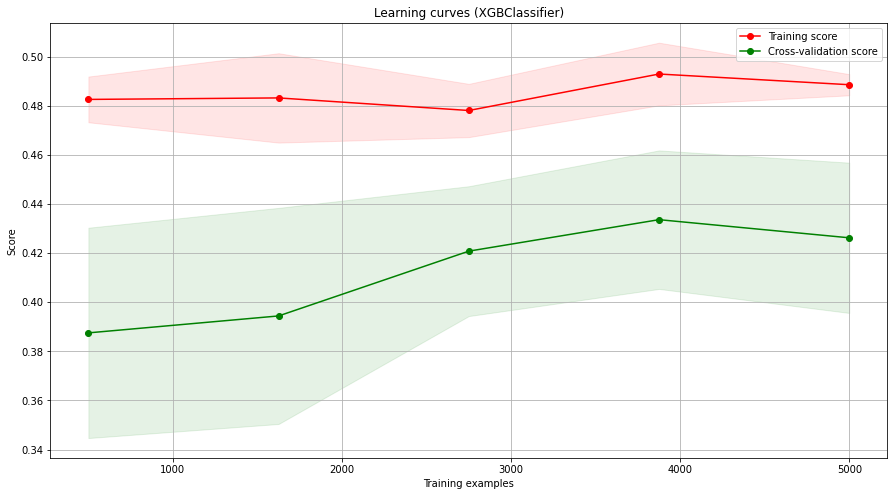

In [808]:
show_learning_curve_plot(final_model, X, y)

Вывод - необходимо большее количество данных

In [1370]:
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_val)
y_test_pred_probs = final_model.predict_proba(X_val)

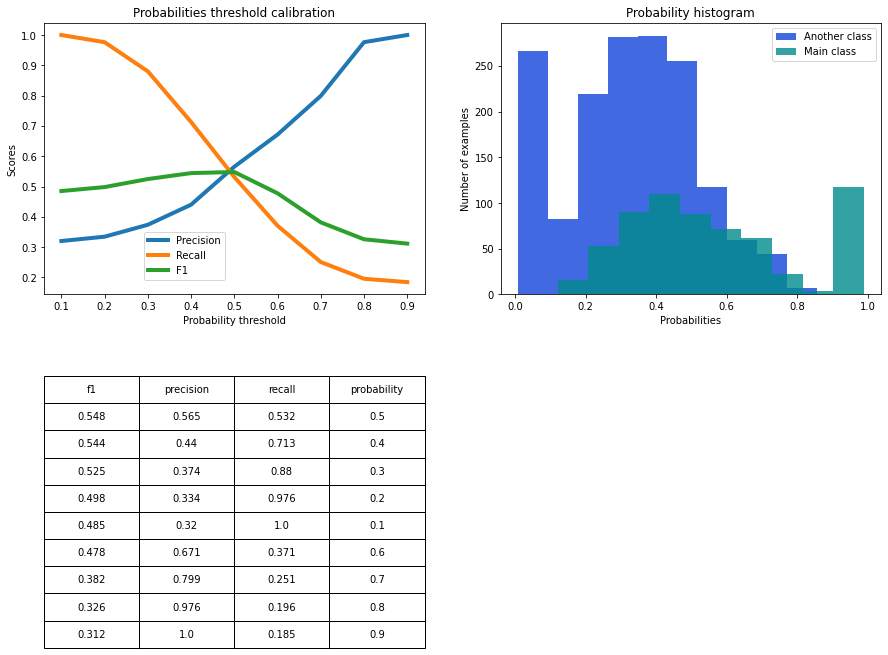

In [1371]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_val)

Вывод - на пересечении линий на первом графике находится найденный лучший результат, значение вероятности отнесения к классу равно 0,5- так и есть в нашей модели

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


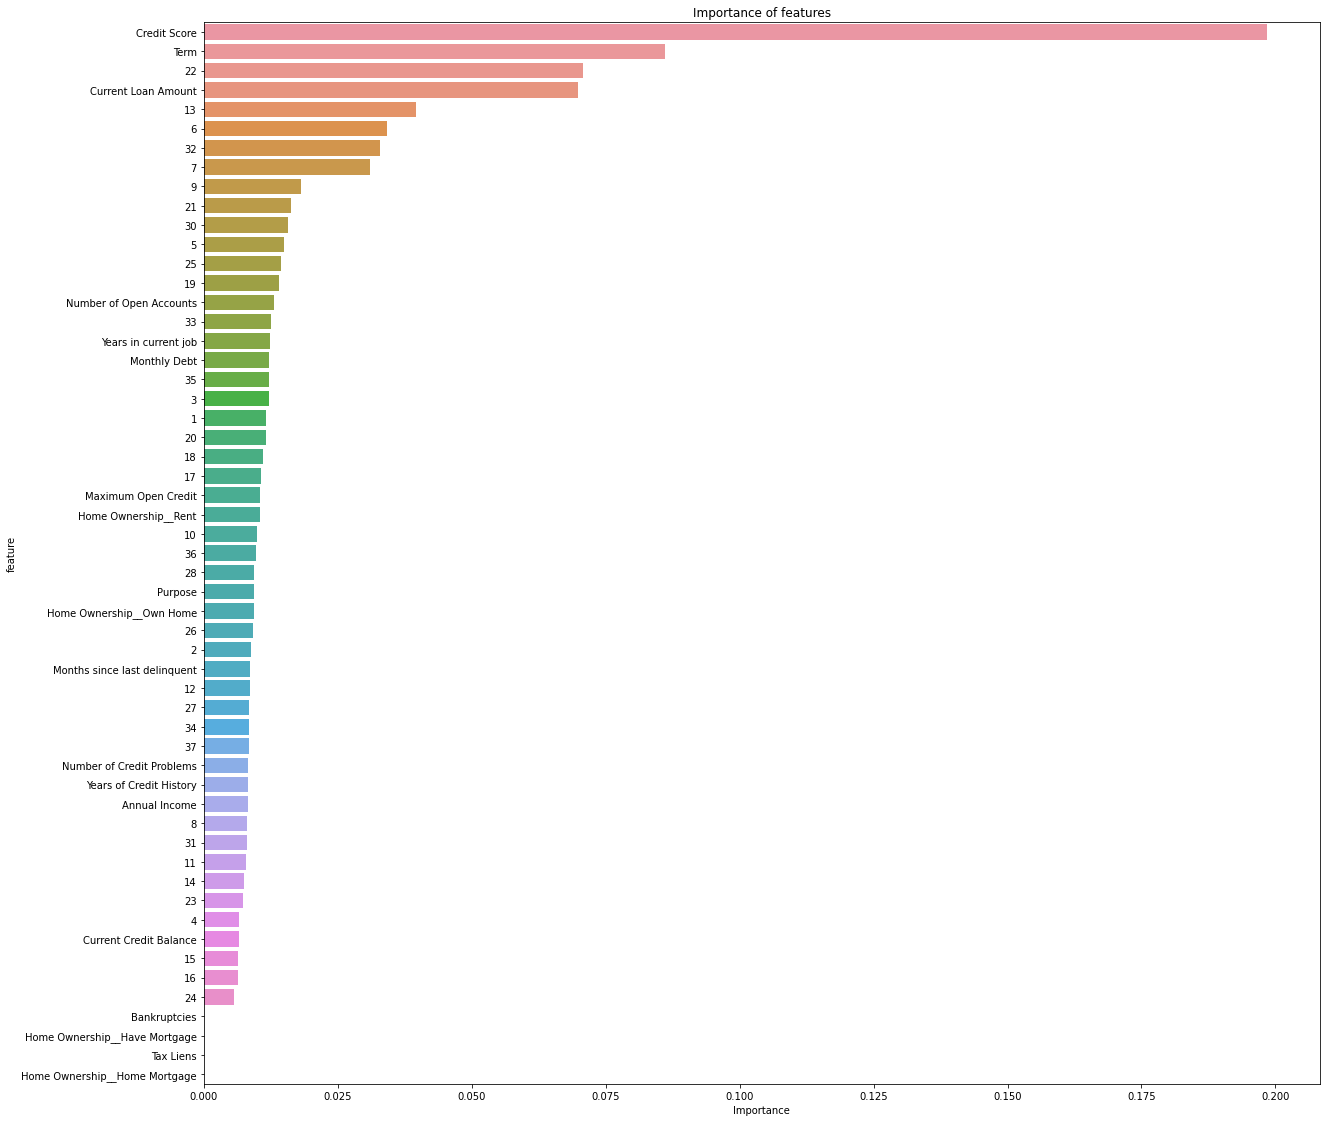

In [1372]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

Как видно из графика - 4 последних признака не влияют на модель, поэтому их можно не использовать

In [202]:
#топ важных признаков
important_features_top

['Credit Score',
 'Term',
 '22',
 'Current Loan Amount',
 '13',
 '6',
 '32',
 '7',
 '9',
 '21',
 '30',
 '5',
 '25',
 '19',
 'Number of Open Accounts']

In [1373]:
# оценим работы модели на самых важных признаках - качество ухудшилось на 2 процента - 
#в данном случае это критично, поэтому отсавляем все признаки кроме 4
model = xgb.XGBClassifier(max_depth=3, n_estimators=130 , reg_alpha= 14,  random_state=21)
model.fit(X_train[important_features_top], y_train)

y_train_preds = model.predict(X_train[important_features_top])
y_test_preds = model.predict(X_val[important_features_top])
y_test_pred_probs = model.predict_proba(X_val[important_features_top])

print_stat(y_train_preds, y_test_preds)

#    train precision 0.76,  recall 0.609, F_1 мера 0.676
#    test precision 0.534,  recall 0.516, F_1 мера 0.525


In [818]:
X_train.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Home Ownership__Have Mortgage',
       'Home Ownership__Home Mortgage', 'Home Ownership__Own Home',
       'Home Ownership__Rent', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34',
       '35', '36', '37'],
      dtype='object')

In [1374]:
main_call = ['Annual Income', 'Years in current job',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Home Ownership__Own Home',
       'Home Ownership__Rent', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34',
       '35', '36', '37']

In [ ]:
#удалим в конечной модели 'Tax Liens' 'Bankruptcies' 'Home Ownership__Home Mortgage' 'Home Ownership__Have Mortgage' без потери качества

### Final model

In [1375]:
final_model = xgb.XGBClassifier(max_depth=3, n_estimators=130 , reg_alpha= 14,  random_state=21)
final_model.fit(X_train[main_call], y_train)

y_train_preds = final_model.predict(X_train[main_call])
y_test_preds = final_model.predict(X_val[main_call])
y_test_pred_probs = final_model.predict_proba(X_val[main_call])

print_stat(y_train_preds, y_test_preds)
get_classification_report(y_train, y_train_preds, y_val, y_test_preds)

#    train precision 0.796,  recall 0.644, F_1 мера 0.712
#    test precision 0.565,  recall 0.532, F_1 мера 0.548
TRAIN

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      3771
           1       0.80      0.64      0.71      2958

    accuracy                           0.77      6729
   macro avg       0.78      0.76      0.76      6729
weighted avg       0.77      0.77      0.77      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1616
           1       0.57      0.53      0.55       634

    accuracy                           0.75      2250
   macro avg       0.69      0.69      0.69      2250
weighted avg       0.75      0.75      0.75      2250

CONFUSION MATRIX

col_0     0    1
row_0           
0      1357  259
1       297  337


### Важность признаков roc_auc

In [ ]:
#('Bankruptcies', 0.5), ('Home Ownership__Have Mortgage', 0.5)

In [172]:
#df_new = pd.read_csv(TRAIN_DATASET_PATH)
#y = df_new['Credit Default']
#col = list(df.columns)

In [179]:
#main_pr = {}
#for elem in col:
#  #print(elem)
#  sc = roc_auc_score( y_true=df_new['Credit Default'], y_score= df[elem])
 # diff = round(sc, 3)
 # main_pr[diff] = elem

#main_pr_sorted = OrderedDict(sorted(main_pr.items(), key=lambda x: x[0]))

#print(main_pr_sorted)

OrderedDict([(0.342, '7'), (0.357, '22'), (0.4, '27'), (0.404, '28'), (0.412, 'Term'), (0.435, '6'), (0.437, '32'), (0.438, '9'), (0.442, '20'), (0.443, '21'), (0.445, '1'), (0.448, 'Annual Income'), (0.454, '35'), (0.455, 'Maximum Open Credit'), (0.462, '14'), (0.464, '4'), (0.465, '19'), (0.469, '31'), (0.471, '2'), (0.478, '30'), (0.48, 'Years of Credit History'), (0.488, '26'), (0.49, '10'), (0.493, '11'), (0.5, 'Home Ownership__Have Mortgage'), (0.502, '36'), (0.503, 'Home Ownership__Own Home'), (0.505, '23'), (0.507, 'Purpose'), (0.51, '33'), (0.511, '24'), (0.514, 'Monthly Debt'), (0.519, '15'), (0.521, 'Months since last delinquent'), (0.524, '17'), (0.531, '8'), (0.533, 'Home Ownership__Rent'), (0.557, '37'), (0.562, '34'), (0.585, 'Credit Score'), (0.604, '25'), (0.609, '13'), (0.632, '18'), (1.0, 'Credit Default')])


In [ ]:
#опеределение веса признака
#col = list(X_train.columns)
#for i in range(len(model_xgb.feature_importances_)):
#  print(f'df = df.drop {col[i]} imp {round(model_xgb.feature_importances_[i], 4)}')

# Сохранение финальной модели

In [1377]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

# Получим значения Credit Default на тестовом датасете и сохраним результаты

In [1378]:
y_test_preds_final = final_model.predict(df_test[main_call])

In [1379]:
df_test_final = pd.read_csv(TEST_DATASET_PATH)

In [1380]:
df_test_final['Credit Default'] = y_test_preds_final

In [ ]:
df_test_final.head()

In [1389]:
df_test_final.to_csv(FINAL_DATASET_PATH_FULL, index=False, encoding='utf-8')

In [1391]:
df_test_final_pred = df_test_final.drop(columns= ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score'])

In [1394]:
df_test_final_pred.to_csv(FINAL_DATASET_PATH_ONLY_PRED, index=False, encoding='utf-8')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
